Compare the reporter editing allele vs endogenous target site allele.


In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import pyBigWig
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle as pkl

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import anndata as ad
import bean as be
from bean.framework._supporting_fn import filter_allele_by_pos
from bean.framework.filter_alleles import _map_alleles_to_filtered, _distribute_alleles_to_filtered
from bean import Allele,Edit

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [22]:
def format_special_chars(str_series):
    str_series = str_series.map(lambda s: s.replace("+", '_').replace("'", "_").replace(" ", '-'))
    return(str_series)

def load_data(sublibrary):
    endo = be.read_h5ad("../results/mapped/minitiling/endo/Sub{}.h5ad".format(sublibrary))
    endo.uns['allele_counts'] = endo.uns['allele_counts'].loc[endo.uns['allele_counts'].allele.map(str)!=""]
    endo.condit["rep"] = endo.condit.index.map(lambda s: s.rsplit("_")[-1])
    endo.layers['X_bcmatch'] = endo.X
    if 'name' in endo.guides.columns:
        endo.guides = endo.guides.set_index("name")
    endo.condit['rep'] = endo.condit.index.map(lambda s: s.rsplit("_")[-1])
    endo_adata = endo[:,endo.condit.rep != "Ctrl"].copy()
    ctrl_adata = endo[:,endo.condit.rep == "Ctrl"].copy()

    #_, endo_adata.uns['sig_allele_counts'] = be.filter_alleles(endo_adata, ctrl_adata, filter_each_sample = True)

    reporter = be.read_h5ad("../results/mapped/minitiling/guide_reporter/Sub{l}/beret_count_Sub{l}.h5ad".format(l=sublibrary))

    reporter.guides.index = format_special_chars(reporter.guides.index)
    reporter.uns['allele_counts'].guide = format_special_chars(reporter.uns['allele_counts'].guide)
    guide_depth = reporter[endo_adata.guides.index, :].X

    endo_adata.layers['repscreen_X'] = guide_depth
    endo_adata.layers['X_bcmatch'] = endo_adata.layers['repscreen_X']/endo_adata.layers['repscreen_X'].sum(axis=0)*endo_adata.X
    endo_adata.guides = endo_adata.guides.merge(reporter.guides.reset_index()[['name','sequence','guide_len']],
                                            on='name', how='left')
    return(endo_adata, reporter)

In [354]:
def get_guide_rel_pos(adata, row):
    guide_len = adata.guides.loc[row.guide, "guide_len"]
    guide_start_pos = 32-6-guide_len
    edits = []
    for edit in deepcopy(row.allele.edits):
        edit.rel_pos -= guide_start_pos
        if edit.rel_pos < 0 or edit.rel_pos > guide_len: continue
        edit.pos = edit.rel_pos
        if edit.ref_base == "A" and edit.alt_base == "G":
            edits.append(edit)
    return(be.Allele(edits))

def filter_reporter_allele(reporter_adata, reporter_df):
    reporter_sig = reporter_df.copy()
    reporter_sig['allele_conv'] = reporter_sig.apply(lambda row:get_guide_rel_pos(reporter_adata, row), axis=1)
    reporter_sig = reporter_sig.loc[reporter_sig.allele_conv.map(str) != ""]
    reporter_sig = reporter_sig[['guide', 'allele_conv'] + reporter_adata.condit.index.tolist()]
    reporter_sig = reporter_sig.rename(columns={'allele_conv' : 'allele'}).fillna(0)
    reporter_sig = reporter_sig.groupby(['guide', 'allele']).sum().reset_index()
    return(reporter_sig)


def get_edit_rates(reporter_adata):
    reporter_adata.uns['allele_counts_filtered'] = filter_reporter_allele(reporter_adata, reporter_adata.uns['allele_counts'])
    reporter_allele_rate = reporter_adata.get_normalized_allele_counts(reporter_adata.uns['allele_counts_filtered'])
    reporter_edits = reporter_adata.get_edit_from_allele('allele_counts_filtered')
    reporter_edit_rate = reporter_adata.get_normalized_allele_counts(reporter_edits)
    return reporter_allele_rate, reporter_edit_rate



## Process endo


In [25]:
lib_direction={"A":"pos", "B":"pos", "C":"neg", "D":"neg"}
def filter_endo_alleles(row, guide_df, lib):
    strand = row.guide.rsplit("_")[-1]
    if strand == lib_direction[lib]:
        target_ref = "A"
        target_alt = "G"
    elif strand != lib_direction[lib]:
        target_ref = "T"
        target_alt = "C"
    edits = []
    for edit in deepcopy(row.allele.edits):
        if edit.ref_base == target_ref and edit.alt_base == target_alt:
            if guide_df.loc[guide_df.name == row.guide, 'guide_len'].item() != 20:
                if strand == lib_direction[lib]:
                    edit.rel_pos -= 1
                    edit.pos -= 1
            if strand != lib_direction[lib]:
                edit.rel_pos = guide_df.loc[guide_df.name == row.guide, 'guide_len'
                                           ].item()-1-edit.rel_pos
                edit.pos = edit.rel_pos
                edit.ref_base='A'
                edit.alt_base='G'
            if strand == "neg":
                edit.strand = '-'
            edits.append(edit)
        else: continue
    return(be.Allele(edits))

def filter_endo_edits(row, guide_df, lib):
    strand = row.guide.rsplit("_")[-1]
    if strand == lib_direction[lib]:
        target_ref = "A"
        target_alt = "G"
    elif strand != lib_direction[lib]:
        target_ref = "T"
        target_alt = "C"
    edit = deepcopy(row.edit)
    
    if edit.ref_base == target_ref and edit.alt_base == target_alt:
        if guide_df.loc[guide_df.name == row.guide, 'guide_len'].item() != 20:
            if strand == lib_direction[lib]:
                edit.rel_pos -= 1
                edit.pos -= 1
        if strand != lib_direction[lib]:
            edit.rel_pos = guide_df.loc[guide_df.name == row.guide, 'guide_len'
                                       ].item()-1-edit.rel_pos
            edit.pos = edit.rel_pos
            edit.ref_base='A'
            edit.alt_base='G'
        if strand == "neg":
            edit.strand = '-'
    return(edit)

def get_endo_edit_rates_sig(endo_adata, lib):
#     try:
#         endo_adata.condit = endo_adata.condit.reset_index()
#     except:
#         pass
    endo_sig = endo_adata.uns['sig_allele_counts'].fillna(0).copy()
    endo_sig['allele_conv'] = endo_sig.apply(
        lambda r: filter_endo_alleles(r, endo_adata.guides, lib),
                                             axis=1)
    endo_sig = endo_sig.loc[endo_sig.allele_conv.map(str) != '', :].drop('allele', axis=1).rename(
        columns={'allele_conv':'allele'}).groupby(['guide', 'allele']).sum().reset_index()
    endo_allele_rate = endo_adata.get_normalized_allele_counts(endo_sig)
    endo_adata.uns['sig_allele_counts_filtered'] = endo_sig
    endo_edits = endo_adata.get_edit_from_allele('sig_allele_counts_filtered')
    endo_edit_rate = endo_adata.get_normalized_allele_counts(endo_edits)
    return(endo_allele_rate, endo_edit_rate)

def get_endo_edit_rates(endo_adata, lib):
#     try:
#         endo_adata.condit = endo_adata.condit.reset_index()
#     except:
#         pass
    endo_sig = endo_adata.uns['allele_counts'].fillna(0).copy()
    endo_sig['allele_conv'] = endo_sig.apply(
        lambda r: filter_endo_alleles(r, endo_adata.guides, lib),
                                             axis=1)
    endo_sig = endo_sig.loc[endo_sig.allele_conv.map(str) != '', :].drop('allele', axis=1).rename(
        columns={'allele_conv':'allele'}).groupby(['guide', 'allele']).sum().reset_index()
    endo_allele_rate = endo_adata.get_normalized_allele_counts(endo_sig)
    endo_adata.uns['allele_counts_conv'] = endo_sig
    
    endo_edits = endo_adata.get_edit_from_allele('allele_counts')
    endo_edits['edit_conv'] = endo_edits.apply(lambda r: filter_endo_edits(r, endo_adata.guides, lib), axis=1)
    endo_edits = endo_edits.loc[endo_edits.edit_conv.map(str) != '', :].drop('edit', axis=1).rename(
        columns={'edit_conv':'edit'}).groupby(['guide', 'edit']).sum().reset_index()
    endo_edit_rate = endo_adata.get_normalized_allele_counts(endo_edits)
    return(endo_allele_rate, endo_edit_rate)

In [355]:
endo_edits = endo_adatas[-1].get_edit_from_allele('allele_counts')
endo_edits['edit_conv'] = endo_edits.apply(lambda r: filter_endo_edits(r, endo_adatas[-1].guides, "D"), axis=1)
endo_edits = endo_edits.loc[endo_edits.edit_conv.map(str) != '', :].drop('edit', axis=1).rename(
    columns={'edit_conv':'edit'}).groupby(['guide', 'edit']).sum().reset_index()
endo_edit_rate = endo_adatas[-1].get_normalized_allele_counts(endo_edits)


## Combine


In [27]:
sublibraries = ["A_Q5", "B_Q5", "C_Q5", "C_Q5U", "D_Q5", "D_Q5U"]
endo_adatas, reporter_adatas = zip(*[load_data(s) for s in sublibraries])

In [82]:
endo_adatas[0].uns['allele_counts']

,guide,allele,SubA_Q5_rep1,SubA_Q5_rep2,SubA_Q5_rep3
0,Intron-1-DNaseHS-1_5314_pos,14:14:+:G>C,16,20,18
1,Intron-1-DNaseHS-1_5314_pos,19:19:+:G>C,26,24,38
2,Intron-1-DNaseHS-1_5314_pos,12:12:+:G>C,39,57,43
3,Intron-1-DNaseHS-1_5314_pos,2:2:+:G>C,17,23,20
4,Intron-1-DNaseHS-1_5314_pos,1:1:+:G>C,23,25,29
...,...,...,...,...,...
16430,Intron-1-DNaseHS-1_5422_neg,"0:0:+:G>A,2:2:+:G>-,3:3:+:G>-,4:4:+:A>-,5:5:+:...",0,0,1
16431,Intron-1-DNaseHS-1_5422_neg,"0:0:+:G>A,1:1:+:G>A,4:4:+:A>-,5:5:+:G>-,6:6:+:...",0,0,1
16432,Intron-1-DNaseHS-1_5422_neg,"0:0:+:G>A,2:2:+:G>T,4:4:+:A>-,5:5:+:G>-,6:6:+:...",0,0,1
16433,Intron-1-DNaseHS-1_5422_neg,"0:0:+:G>-,1:1:+:G>-,2:2:+:G>-,3:3:+:G>-,4:4:+:...",0,0,1


In [28]:
guide_info = pd.concat([reporter_adatas[i].guides for i in range(len(reporter_adatas))], axis=0)

In [29]:
guide_info = guide_info.drop_duplicates()

In [176]:
libraries=["A","B","C","C","D","D"]

endo_allele_rates, endo_edit_rates = zip(*[
    get_endo_edit_rates(endo_adatas[i],libraries[i]) for i in range(len(endo_adatas))])
reporter_allele_rates, reporter_edit_rates = zip(*[get_edit_rates(r) for r in reporter_adatas])

In [30]:

data_dict={
    'sublibraries':sublibraries,
    'endo_alelle_rates':endo_allele_rates,
    'endo_edit_rates':endo_edit_rates,
    'reporter_allele_rates':reporter_allele_rates,
    'reporter_edit_rates':reporter_edit_rates,
    'guide_info':guide_info
}
with open('mini_tiling_screen_data_endoUnfiltered_n20.pkl', 'wb') as handle:
    pkl.dump(data_dict, handle)

In [22]:
import pickle as pkl
with open('mini_tiling_screen_data_endoUnfiltered_n20.pkl', 'rb') as handle:
    data_dict = pkl.load(handle)
sublibraries=data_dict['sublibraries']

endo_allele_rates = data_dict['endo_alelle_rates']
endo_edit_rates = data_dict['endo_edit_rates']

reporter_allele_rates = data_dict['reporter_allele_rates']
reporter_edit_rates = data_dict['reporter_edit_rates']

In [66]:
def get_cmap(series):
    df = pd.DataFrame(series)
    df['c'] = sns.color_palette('tab10', len(df))
    cmap = df.set_index(0).to_dict()['c']
    return(cmap)

In [67]:
def filter_allele_counts_by_pos(count_df,
    rel_pos_start = 0, rel_pos_end = 32,
    filter_rel_pos = True,
    map_to_filtered = True, distribute = False,
    jaccard_threshold = 0.1):
    '''
    Filter alleles based on barcode matched counts, allele counts, 
    or proportion

    Keyword arguments:
    map_to_filtered -- Map allele to the closest filtered allele to preserve total allele count. Ignores the case where there is no alleles filtered.
    '''
    allele_count_df = count_df.copy()
    filtered_allele, filtered_edits = \
        zip(*allele_count_df.allele.map(lambda a:
            filter_allele_by_pos(a, rel_pos_start, rel_pos_end, filter_rel_pos)))
    allele_count_df.loc[:, "allele"] = filtered_allele
    # Hashing on Allele object messes up the order. Converting it to str and back to allele for groupby.
    allele_count_df["str_allele"] = allele_count_df.allele.map(str)
    allele_count_df = allele_count_df.groupby(["guide", "str_allele"]).sum().reset_index()
    allele_count_df.insert(1, "allele", allele_count_df.str_allele.map(lambda s: Allele.from_str(s)))
    allele_count_df = allele_count_df.drop("str_allele", axis=1)
    print("{} edits filtered from {} alleles.".format(sum(filtered_edits), len(filtered_edits)))
    if map_to_filtered:
        print("mapping filtered alleles ...")
        if distribute:
            allele_count_df = _distribute_alleles_to_filtered(count_df, allele_count_df, jaccard_threshold=jaccard_threshold)
        else:
            allele_count_df = _map_alleles_to_filtered(count_df, allele_count_df, jaccard_threshold=jaccard_threshold)
    return(allele_count_df)
    
    

In [68]:
def get_edit_from_allele(allele_df):
    df = allele_df.copy()
    df["edits"] = df.allele.map(lambda a: str(a).split(","))
    df = df.explode("edits").groupby(["guide", "edits"]).sum()
    df = df.reset_index().rename(columns={"edits":"edit"})
    df["edit"] = df.edit.map(lambda s: Edit.from_str(s))
    return(df)

In [69]:
def get_filtered_allele_rates(i):
    af = filter_allele_counts_by_pos(reporter_allele_rates[i], 3, 8)
    ef = filter_allele_counts_by_pos(endo_allele_rates[i], 3, 8)
    allele_rates = af.merge(ef, on=['guide', 'allele'],how='outer').fillna(0).sort_values('guide')
    return(allele_rates)

In [70]:
def filter_plot(i, rep=1):
    af = filter_allele_counts_by_pos(reporter_allele_rates[i], 3, 8)
    ef = filter_allele_counts_by_pos(endo_allele_rates[i], 3, 8)
    allele_rates = af.merge(ef, on=['guide', 'allele'],how='outer').fillna(0).sort_values('guide').rename(columns={f'rep{rep}_Sub{sublibraries[i]}':"reporter", f'Sub{sublibraries[i]}_rep1':"endo"})
    allele_rates['allele'] = allele_rates.allele.map(str)
    fig=px.scatter(allele_rates, x='reporter', y='endo', 
          width=500,height=300, color='guide', hover_data=['allele'])
    return(fig, allele_rates)

In [71]:
markers_strand={"pos":"P", "neg":"o"}

In [63]:
def filter_edit_plot(i,rep=1):
    raf = filter_allele_counts_by_pos(reporter_allele_rates[i], 3, 8)
    eaf = filter_allele_counts_by_pos(endo_allele_rates[i], 3, 8)
    ref = get_edit_from_allele(raf)
    eef = get_edit_from_allele(eaf)
    edit_rates = ref.merge(eef, on=['guide', 'edit'],how='outer').fillna(0).sort_values('guide').sort_values('guide').rename(columns={f'rep{rep}_Sub{sublibraries[i]}':"reporter", f'Sub{sublibraries[i]}_rep1':"endo"}, )
    edit_rates['edit'] = edit_rates.edit.map(str)
    edit_rates['strand'] = edit_rates.guide.map(lambda s:markers_strand[s.rsplit("_",1)[-1]])
    fig=px.scatter(edit_rates, x='reporter', y='endo', title=f"Sub{sublibraries[i]} rep{rep}",width=550,height=400, color='guide', hover_data=['edit'], symbol='strand')
    return(fig, edit_rates)

In [64]:
def edit_plot(i, rep=1):
    edit_rates = reporter_edit_rates[i].merge(endo_edit_rates[i], on=['guide', 'edit'], how='left').rename(columns={f'rep{rep}_Sub{sublibraries[i]}':"reporter", f'Sub{sublibraries[i]}_rep1':"endo"}, )
    edit_rates['edit'] = edit_rates.edit.map(str)
    edit_rates['strand'] = edit_rates.guide.map(lambda s:markers_strand[s.rsplit("_",1)[-1]])
    
    fig=px.scatter(edit_rates, x='reporter', y='endo', title=f"Sub{sublibraries[i]} rep{rep}", width=550,height=400, color='guide', hover_data=['edit'])
    return(fig)
def allele_plot(i, rep=1):
    allele_rates = reporter_allele_rates[i].merge(endo_allele_rates[i], on=['guide', 'allele'], how='left').rename(columns={f'rep{rep}_Sub{sublibraries[i]}':"reporter", f'Sub{sublibraries[i]}_rep1':"endo"}, )
    allele_rates['allele'] = allele_rates.allele.map(str)
    allele_rates['strand'] = allele_rates.guide.map(lambda s:markers_strand[s.rsplit("_",1)[-1]])
    
    fig=px.scatter(allele_rates, x='reporter', y='endo', title=f"Sub{sublibraries[i]} rep{rep}", width=550,height=400, color='guide', hover_data=['allele'])
    return(fig)

In [36]:
def edits_normed_plot(i, rep=1):
    fig, ers = filter_edit_plot(i, rep)
    norm_df = ers.groupby('guide').transform(lambda x: x / x.max())
    norm_df['guide'], norm_df['edit'] = ers['guide'], ers['edit']
    norm_df['strand'] = norm_df.guide.map(lambda s:markers_strand[s.rsplit("_",1)[-1]])
    fig=px.scatter(norm_df, x='reporter', y='endo', title=f"Sub{sublibraries[i]} rep{rep}", width=550,height=400, color='guide', hover_data=['edit'], symbol='strand', labels={"x":"normed reporter", "y":"normed endo"})
    return(fig, norm_df)

In [37]:
def alleles_normed_plot(i, rep=1):
    fig, ers = filter_plot(i, rep)
    norm_df = ers.groupby('guide').transform(lambda x: x / x.max())
    norm_df['guide'], norm_df['allele'] = ers['guide'], ers['allele']
    norm_df['strand'] = norm_df.guide.map(lambda s:markers_strand[s.rsplit("_",1)[-1]])
    fig=px.scatter(norm_df, x='reporter', y='endo', title=f"Sub{sublibraries[i]} rep{rep}", width=550,height=400, color='guide', hover_data=['allele'], symbol='strand', labels={"x":"normed reporter", "y":"normed endo"})
    return(fig, norm_df)

111 edits filtered from 93 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

109 edits filtered from 111 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

736 edits filtered from 371 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/11 [00:00<?, ?it/s]

503 edits filtered from 336 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/11 [00:00<?, ?it/s]

228 edits filtered from 171 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

242 edits filtered from 220 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

212 edits filtered from 164 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

222 edits filtered from 204 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

485 edits filtered from 291 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

191 edits filtered from 168 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

447 edits filtered from 273 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

181 edits filtered from 159 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

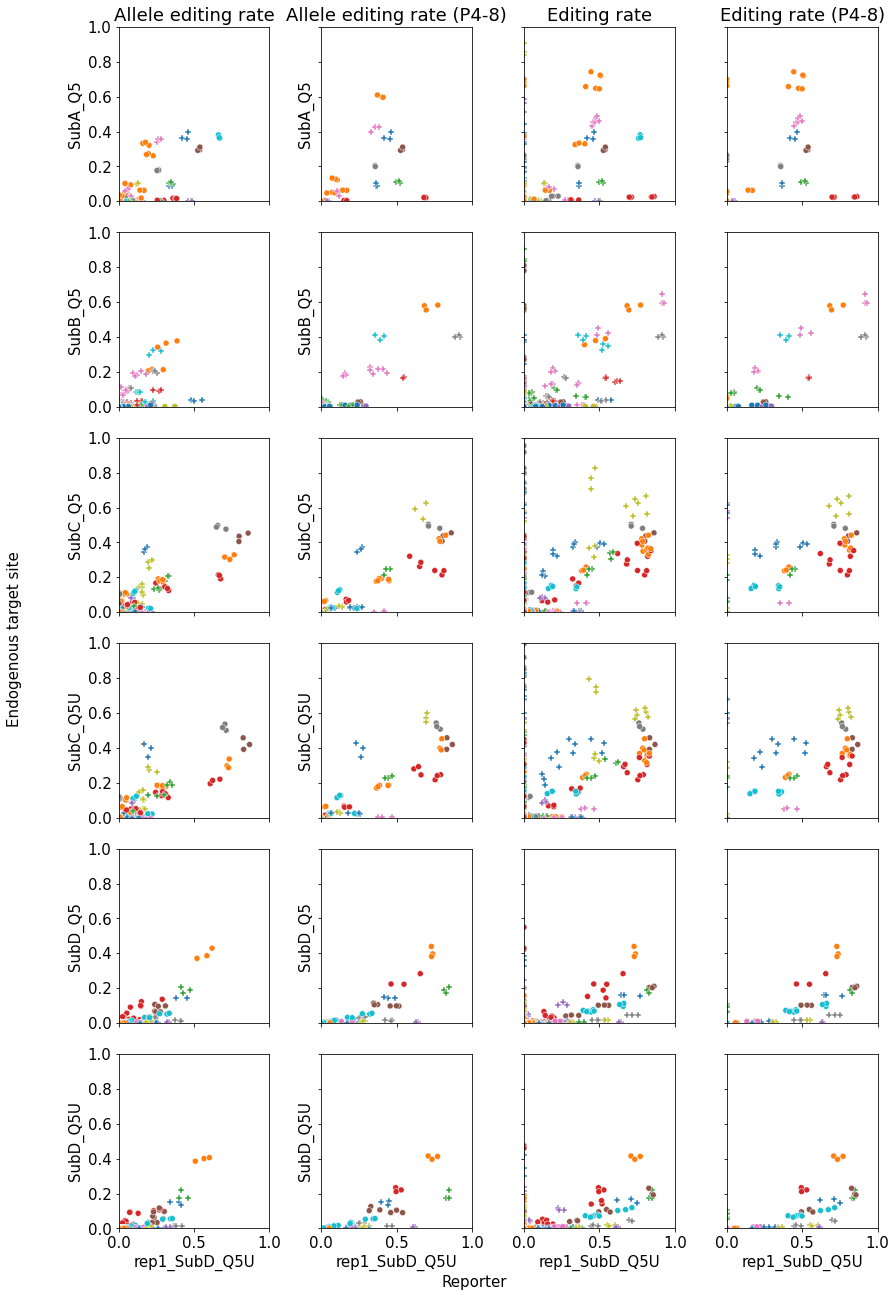

In [356]:
markers=["o","P", "D"]
markers_strand={"pos":"P", "neg":"o"}
fig, ax = plt.subplots(6, 4, figsize=(12, 18), sharex=True, sharey=True,)
edit_rates_list = []
window_edit_rates_list = []
ax[0, 0].set_title("Allele editing rate")
ax[0, 1].set_title("Allele editing rate (P4-8)")
ax[0, 2].set_title("Editing rate")
ax[0, 3].set_title("Editing rate (P4-8)")
allele_rates_list = []
for i in range(len(endo_allele_rates)):
    allele_rates = reporter_allele_rates[i].merge(endo_allele_rates[i], on=['guide', 'allele'], how='left').fillna(0).sort_values('guide')
    allele_rates_list.append(allele_rates)
    color_map = get_cmap(allele_rates['guide'].unique())
    allele_rates_window = get_filtered_allele_rates(i)
    allele_rates['strand'] = allele_rates.guide.map(lambda s: s.split("_")[-1])
    allele_rates_window['strand'] = allele_rates_window.guide.map(lambda s: s.split("_")[-1])
    ax[i, 0].set_ylabel("Sub{}".format(sublibraries[i]))
    ax[i, 1].set_ylabel("Sub{}".format(sublibraries[i]))
    for j, rep in enumerate(['rep1', 'rep2', 'rep3']):
        sns.scatterplot(data=allele_rates, x='{}_Sub{}'.format(rep, sublibraries[i]), 
                         y='Sub{}_{}'.format(sublibraries[i], rep),
                       hue='guide',
                        palette=color_map,
                       style='strand', markers= markers_strand,
                       ax=ax[i, 0],
                       legend=False)
        sns.scatterplot(data=allele_rates_window, x='{}_Sub{}'.format(rep, sublibraries[i]), 
                         y='Sub{}_{}'.format(sublibraries[i], rep),
                       hue='guide',
                        palette=color_map,
                       style='strand', markers= markers_strand,
                       ax=ax[i, 1],
                       legend=False)
        #ax[i, 0].set_xlabel("reporter site allele proportion")
        #ax[i, 0].set_ylabel('endogenous target site allele proportion')
    edit_rates = reporter_edit_rates[i].merge(endo_edit_rates[i], on=['guide', 'edit'],
                                             how='outer').fillna(0).sort_values('guide')
    
    edit_rates['strand'] = edit_rates.guide.map(lambda s: s.split("_")[-1])
    edit_rates_w = edit_rates.loc[edit_rates.edit.map(lambda e: (e.rel_pos < 8 and e.rel_pos >= 3) & ((e.ref_base == "A") & (e.alt_base == "G"))),]
    edit_rates_list.append(edit_rates)
    window_edit_rates_list.append(edit_rates_w)    
    for j, rep in enumerate(['rep1', 'rep2', 'rep3']):
        sns.scatterplot(data=edit_rates, x='{}_Sub{}'.format(rep, sublibraries[i]), 
                         y='Sub{}_{}'.format(sublibraries[i], rep),
                       ax=ax[i, 2],
                       hue="guide", 
                        palette=color_map,
                       #marker=markers[j],
                       style='strand', markers= markers_strand,
                       legend=False)
        sns.scatterplot(data=edit_rates_w,
                        x='{}_Sub{}'.format(rep, sublibraries[i]), 
                 y='Sub{}_{}'.format(sublibraries[i], rep),
               ax=ax[i, 3],
               hue="guide", 
                        palette=color_map,
               #marker=markers[j],
                    style='strand',
                markers= markers_strand,
               legend=False)
        #ax[i, 1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        #ax[i, 1].set_xlabel("reporter site edit proportion")
        #ax[i, 1].set_ylabel('endogenous target site edit proportion')
plt.setp(ax, ylim=(0,1),xlim=(0,1))
fig.text(0.5, 0, 'Reporter', ha='center')
fig.text(-0.04, 0.5, 'Endogenous target site', va='center', rotation='vertical')
plt.tight_layout()

In [345]:
edit_rates_window_list = [edit_rates.loc[edit_rates.edit.map(lambda e: e.rel_pos < 8 and e.rel_pos >= 3)] for edit_rates in edit_rates_list]

In [46]:
def wide_to_long(df):
    df_list = []
    lib = df.columns[2].split("_Sub")[-1]
    for rep in range(1, 4):
        rep_df = df[['guide', 'edit', 'strand'] + [f"rep{rep}_Sub{lib}", f"Sub{lib}_rep{rep}"]]
        rep_df.columns=['guide', 'edit', 'strand', 'reporter', 'endo']
        rep_df['rep'] = rep   
        rep_df['lib'] = lib
        df_list.append(rep_df)
    return pd.concat(df_list)


In [47]:
edit_rates_window_list = [wide_to_long(df) for df in edit_rates_window_list]

<ipython-input-46-8de350015ef1>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-8de350015ef1>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-8de350015ef1>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-8de3500

In [48]:
edit_rates_window = pd.concat(edit_rates_window_list)


In [81]:
#edit_rates_window.to_csv("20221221_edit_rates_window_n20.csv")

In [4]:
edit_rates_window = pd.read_csv("20221221_edit_rates_window_n20.csv")

In [6]:
edit_rates_window['edit'] = edit_rates_window.edit.map(lambda s: be.framework.Edit.Edit.from_str(s))

In [17]:
guide_info = pd.read_csv("../resources/gRNA_info/LDLRCDS_gRNA_bean.csv")

In [26]:
guide_info["name"] = format_special_chars(guide_info["name"])

### Locus wise accessibility


In [10]:
dnase = pyBigWig.open("../resources/accessibility/ENCFF113VII.hg19.bw")
atac = pyBigWig.open("../resources/accessibility/ENCFF262URW.hg19.bw")
lmnb = pyBigWig.open("../resources/accessibility/SRX4654321.bw.1")

def get_accessibility(guide_name, pos_list, track):
    guide_start_pos = guide_info.loc[guide_name, "start_pos"]
    vals = []
    for pos in pos_list:
        try:
            vals.append(track.values("chr19", guide_start_pos + pos, guide_start_pos + pos + 1))
        except:
            print(guide_start_pos, pos)
    return(np.array(vals))

In [11]:
def get_accessibility_single(guide_name, pos, track):
    guide_start_pos = guide_info.loc[guide_name, "start_pos"]
    return np.nanmean(np.array(track.values("chr19", guide_start_pos + pos-100, guide_start_pos + pos + 100)))

In [12]:
edit_rates_window['edit_pos'] = edit_rates_window.edit.map(lambda e: e.pos)
edit_rates_window['region'] = edit_rates_window.lib.map(lambda s: s.rsplit("_")[0])


In [13]:
edit_rates_window_no = edit_rates_window.loc[edit_rates_window.guide != "Intron-1-DNaseHS-1_5344_neg",:]

In [15]:
edit_rates_window

,Unnamed: 0.1,Unnamed: 0,guide,edit,strand,reporter,endo,rep,lib,edit_pos,region,dnase_acc,log_dnase_acc,atac_acc,log_atac_acc,lmnb,log_lmnb,ratio,ratio_pad
0,0,2,Intron-1-DNaseHS-1_5314_pos,6:6:+:A>G,pos,0.363289,0.086108,1,A_Q5,6,A,3.411054,1.484114,980.269350,6.888847,0.029693,0.029260,-1.356883,-1.110700
1,1,3,Intron-1-DNaseHS-1_5323_neg,4:4:-:A>G,neg,0.142446,0.064456,1,A_Q5,4,A,3.421432,1.486464,982.907655,6.891532,0.030019,0.029577,-0.716594,-0.519619
2,2,6,Intron-1-DNaseHS-1_5332_pos,4:4:+:A>G,pos,0.495024,0.112803,1,A_Q5,4,A,3.312679,1.461559,948.110179,6.855525,0.028484,0.028086,-1.414021,-1.208287
3,3,8,Intron-1-DNaseHS-1_5344_neg,5:5:-:A>G,neg,0.861985,0.027065,1,A_Q5,5,A,3.289488,1.456167,941.479276,6.848514,0.028484,0.028086,-3.158113,-2.470981
4,4,9,Intron-1-DNaseHS-1_5344_neg,7:7:-:A>G,neg,0.713075,0.024518,1,A_Q5,7,A,3.274028,1.452557,937.021525,6.843773,0.028484,0.028086,-3.042036,-2.326318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,289,45,12_3180_neg,3:3:-:A>G,neg,0.439649,0.064626,3,D_Q5U,3,D,0.075714,0.072985,3.891711,1.587542,0.028484,0.028086,-1.795980,-1.452015
290,290,46,12_3180_neg,4:4:-:A>G,neg,0.405999,0.072616,3,D_Q5U,4,D,0.075846,0.073108,3.842238,1.577377,0.028484,0.028086,-1.616474,-1.313429
291,291,47,12_3180_neg,6:6:-:A>G,neg,0.621068,0.102473,3,D_Q5U,6,D,0.076111,0.073354,3.743551,1.556786,0.028484,0.028086,-1.724697,-1.481881
292,292,52,12_3197_pos,4:4:+:A>G,pos,0.164243,0.000582,3,D_Q5U,4,D,0.077144,0.074313,2.745583,1.320577,0.028484,0.028086,-2.801258,-1.443506


In [32]:
guide_info.loc[guide_info.name.map(lambda s: "Intron-1-DNaseHS-1_5314_pos" in s)]

,Unnamed: 0,name,Region,pos,Strand,gRNA,Reporter,gRNA_barcode,5-nt PAM,targetPos,pos_seq,start_pos
7046,7046,Intron-1-DNaseHS-1_5314_pos,Intron 1 DNaseHS 1,5314,pos,AGGCGGAGGCGGGCGTCGGG,CGGTGGAGGCGGAGGCGGGCGTCGGGAGGACG,TTCT,AGGAC,11201182.0,AGGCGGAGGCGGGCGTCGGG,11201177


In [34]:
guide_info = guide_info.set_index("name")

In [35]:
edit_rates_window['dnase_acc']=edit_rates_window.apply(lambda row: get_accessibility_single(row.guide, row.edit_pos, dnase), axis=1)
edit_rates_window['log_dnase_acc']=edit_rates_window['dnase_acc'].map(lambda x: np.log(x+1))

In [36]:
edit_rates_window['atac_acc']=edit_rates_window.apply(lambda row: get_accessibility_single(row.guide, row.edit_pos, atac), axis=1)
edit_rates_window['log_atac_acc']=edit_rates_window['atac_acc'].map(lambda x: np.log(x+1))

In [37]:
edit_rates_window['lmnb']=edit_rates_window.apply(lambda row: get_accessibility_single(row.guide, row.edit_pos, lmnb), axis=1)

edit_rates_window['log_lmnb']=edit_rates_window['lmnb'].map(lambda x: np.log(x+1))

<ipython-input-11-58a8887fce4e>:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(track.values("chr19", guide_start_pos + pos-100, guide_start_pos + pos + 100)))


In [38]:
edit_rates_window['ratio']= np.log(edit_rates_window.endo + 0.01)-np.log(edit_rates_window.reporter+0.01)
edit_rates_window['ratio_pad']= np.log(edit_rates_window.endo + 0.05)-np.log(edit_rates_window.reporter+0.05)


In [ ]:
# edit_rates_window.to_csv("20221221_edit_rates_window_n20.csv")

In [39]:
edit_rates_window_no = edit_rates_window.loc[edit_rates_window.guide != "Intron-1-DNaseHS-1_5344_neg",:]

In [42]:
edit_rates_window[['log_atac_acc', 'log_dnase_acc', 'log_lmnb', 'ratio']].corr().style.background_gradient()


,log_atac_acc,log_dnase_acc,log_lmnb,ratio
log_atac_acc,1.000000,0.899460,0.203262,0.540431
log_dnase_acc,0.899460,1.000000,0.595151,0.473163
log_lmnb,0.203262,0.595151,1.000000,0.221013
ratio,0.540431,0.473163,0.221013,1.000000


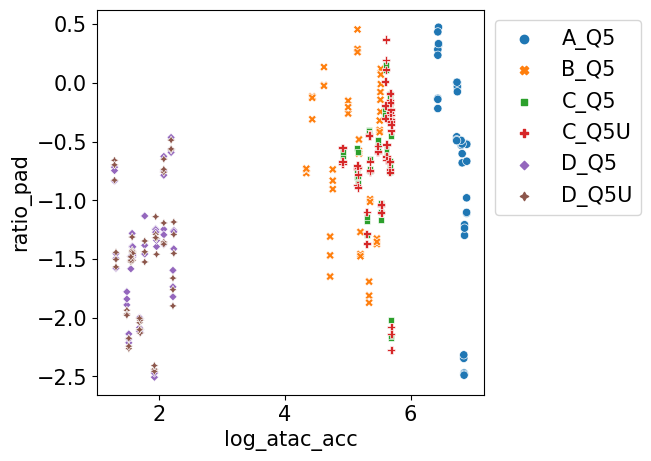

In [43]:
sns.scatterplot(data = edit_rates_window, x="log_atac_acc", y="ratio_pad", hue ="lib", style='lib', )
plt.legend(bbox_to_anchor=(1, 1))

In [45]:
x = edit_rates_window_no.log_atac_acc
y = edit_rates_window_no.ratio_pad
x = sm.add_constant(x)

model = sm.RLM(y, x)



mdf=model.fit()
print(mdf.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              ratio_pad   No. Observations:                  288
Model:                            RLM   Df Residuals:                      286
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 15 Aug 2023                                         
Time:                        22:59:26                                         
No. Iterations:                    18                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9458      0.077    -25.347   

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


WARNING @ Wed, 16 Aug 2023 11:04:56:
	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument. 



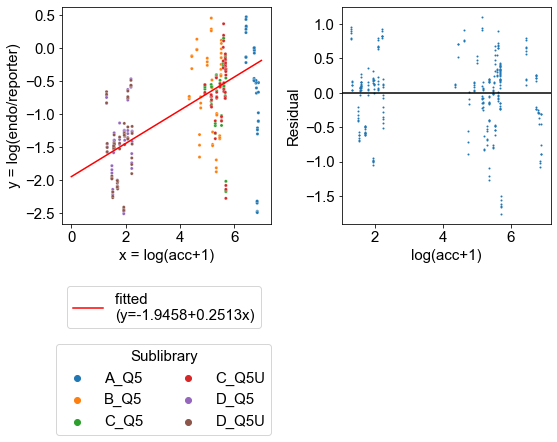

In [80]:
plt.style.use('jr')
fig, ax = plt.subplots(1, 2, figsize=(8,4))

xpt = np.arange(0, 8)
X= sm.add_constant(xpt)
fit_line, = ax[0].plot(xpt, mdf.predict(X), label='fitted \n(y=-1.9458+0.2513x)', color='red')
plt.legend()
sns.scatterplot(data = edit_rates_window, x="log_atac_acc", y="ratio_pad", hue ="lib", ax=ax[0], s=10)
ax[0].get_legend().remove()
ax[0].set_ylabel("y = log(endo/reporter)")
ax[0].set_xlabel("x = log(acc+1)")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.3, -0.2), loc="upper center", ncol=2, title="Sublibrary")
legend2 = fig.legend(handles=[fit_line], loc='upper center', bbox_to_anchor=(0.3, 0))

ax[1].scatter(x.log_atac_acc, y-mdf.predict(x), s=1)
ax[1].set_ylabel("Residual")
ax[1].set_xlabel("log(acc+1)")
ax[1].axhline(0, color="black")
ax[1].get_legend().remove()
plt.tight_layout()
fig.savefig("FigSX_accessibility_fit_residual_plot.pdf")